In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive.mount('/gdrive')

Mounted at /gdrive


# Thông tin sinh viên

Họ tên: Phan Anh Lộc

MSSV: 19521766

Bài thực hành số 7



# Import các thư viện

In [3]:
import cv2
from scipy import ndimage
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os

# Đường dẫn môn học

In [4]:
dir_monhoc = '/gdrive/MyDrive/CS231.M12.KHCL'
dir_baitap = os.path.join(dir_monhoc, 'Baitap','Baitap7')
dir_img = os.path.join(dir_baitap, 'img')

In [5]:
butterfly_path = os.path.join(dir_img, 'butterfly.jpg')
home_path = os.path.join(dir_img, 'home.jpg')
simple_path = os.path.join(dir_img, 'simple.jpg')
left_path= os.path.join(dir_img,'left.jpg')
right_path= os.path.join(dir_img,'right.jpg')

## Yêu Cầu 1: Keyspoint and Decriptors

# Brief

In [6]:
def briefDescriptor(path_filename):
  img = cv2.imread(path_filename)

  star = cv2.xfeatures2d.StarDetector_create()
  kp = star.detect(img,None)
  brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
  kp, des = brief.compute(img, kp)

  img_rst = cv2.drawKeypoints(img,kp,None,(0,255,0),flags=0)
  cv2_imshow(np.hstack((img, img_rst)))
  return kp, des

- Ảnh butterfly

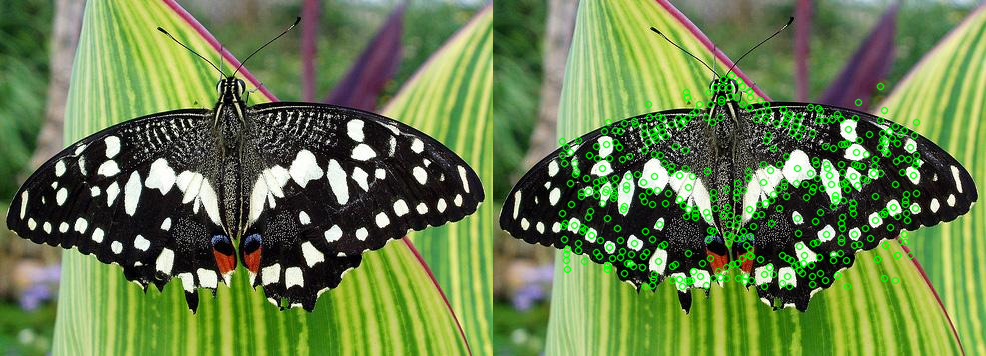

In [7]:
butterfly = briefDescriptor(butterfly_path)

- Ảnh home

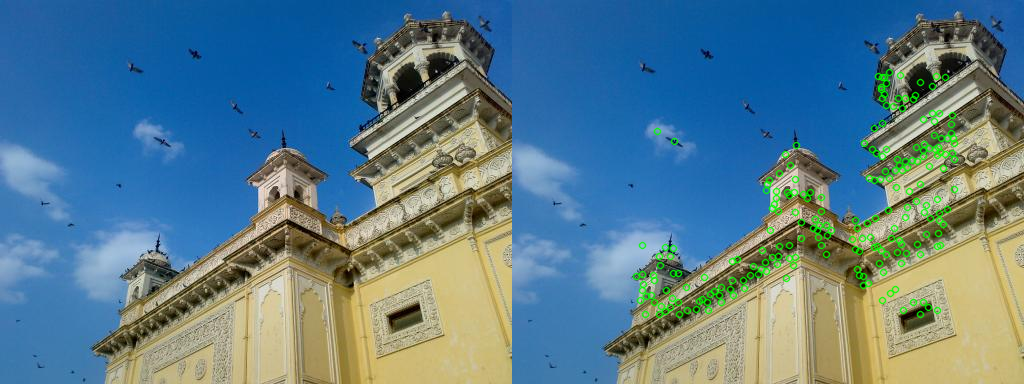

In [8]:
home = briefDescriptor(home_path)

- Ảnh simple

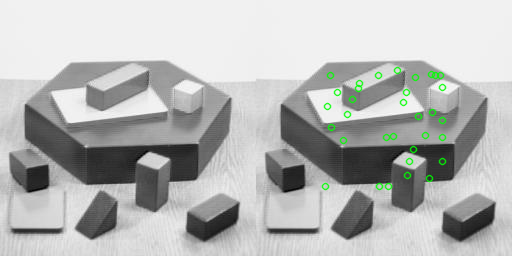

In [9]:
simple = briefDescriptor(simple_path)

# ORB

In [10]:
def orbDescriptor(path_filename, threshold=500):
  img = cv2.imread(path_filename)
  
  orb = cv2.ORB_create(threshold)
  kp, des = orb.detectAndCompute(img,None)

  img_rst = cv2.drawKeypoints(img,kp,None,(0,255,0),flags=0)
  cv2_imshow(np.hstack((img, img_rst)))
  return kp,  des

- Ảnh butterfly

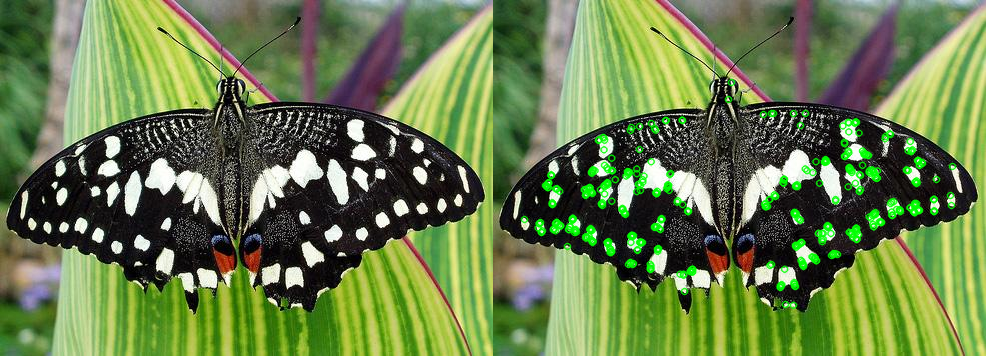

In [11]:
butterfly = orbDescriptor(butterfly_path)

- Ảnh home

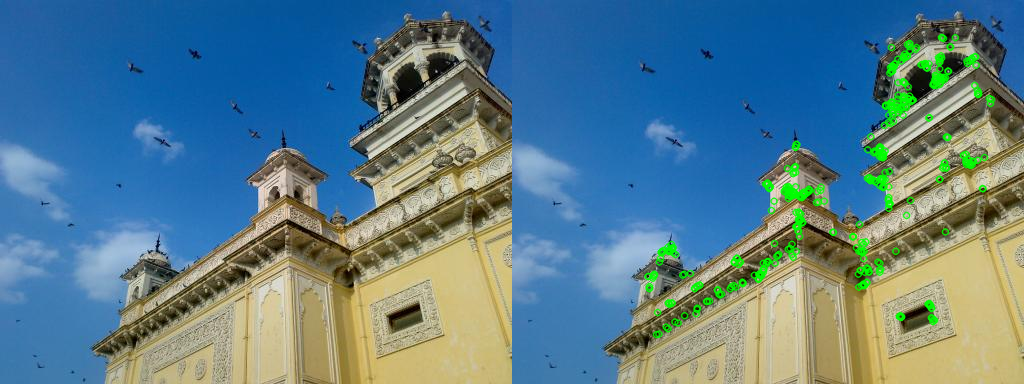

In [12]:
home = orbDescriptor(home_path)

- Ảnh simple

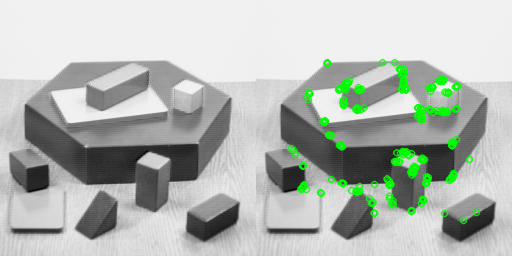

In [13]:
simple = orbDescriptor(simple_path)

## Yêu cầu 2: Feature matching 

# Brute-force matching

In [14]:
def BFMatching(path_filename1, path_filename2, descriptor=orbDescriptor):
  img1 = cv2.imread(path_filename1)
  img2 = cv2.imread(path_filename2)
  kp1, des1 = descriptor(path_filename1)
  kp2, des2 = descriptor(path_filename2)

  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1, des2, k=2)

  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches[:20],None,flags=2)
  cv2_imshow(img3)

# Brief Descriptors

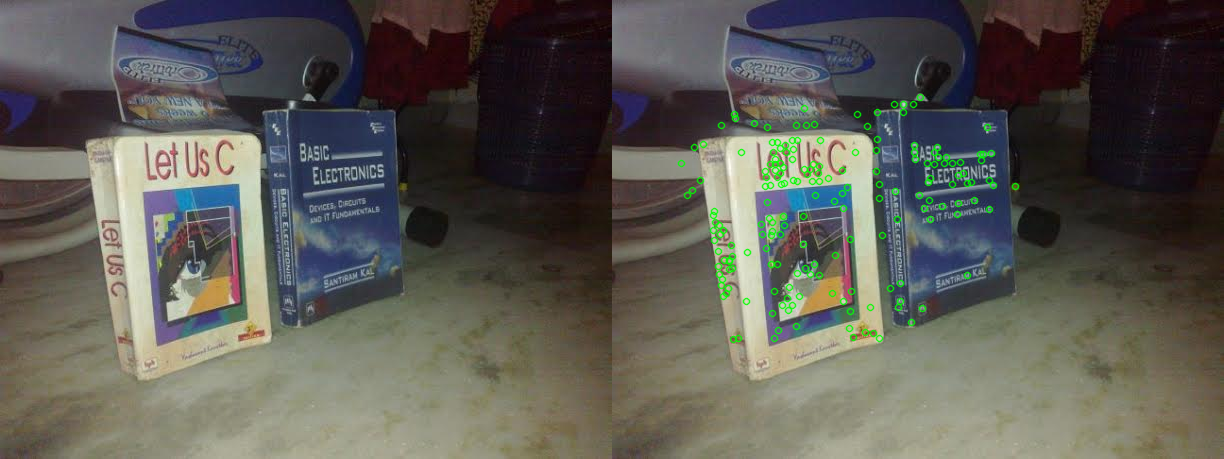

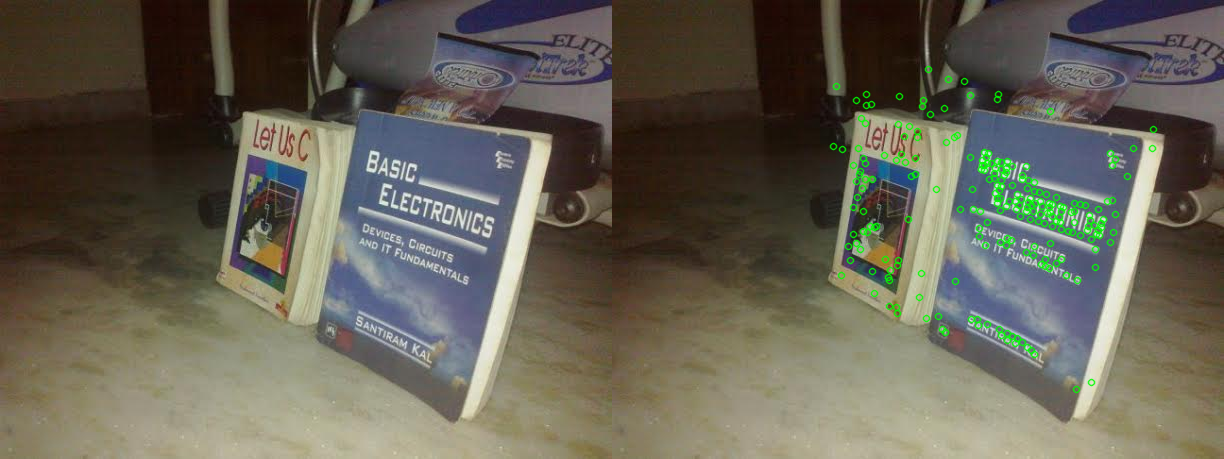

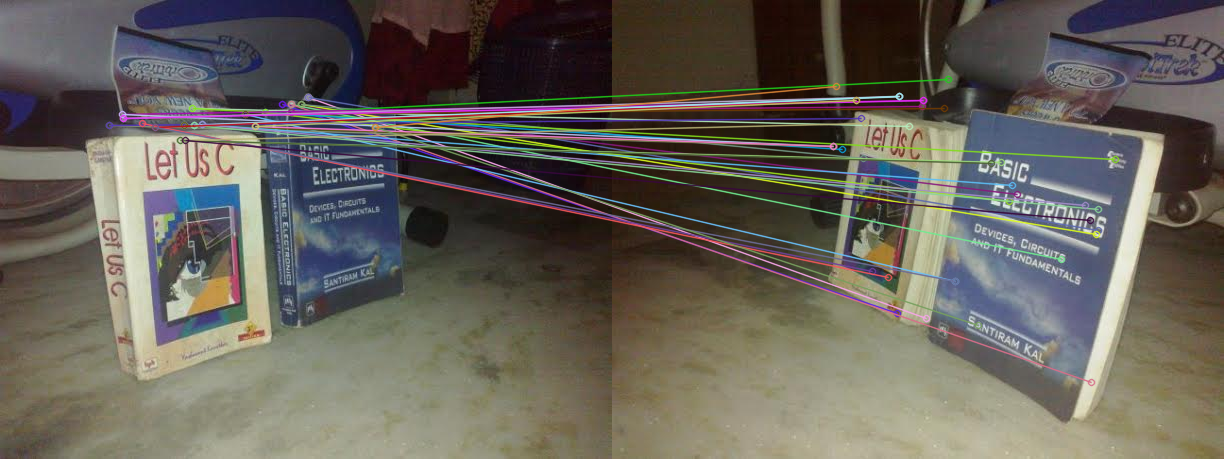

In [15]:
BFMatching(left_path, right_path, briefDescriptor)

# Orb Descriptors

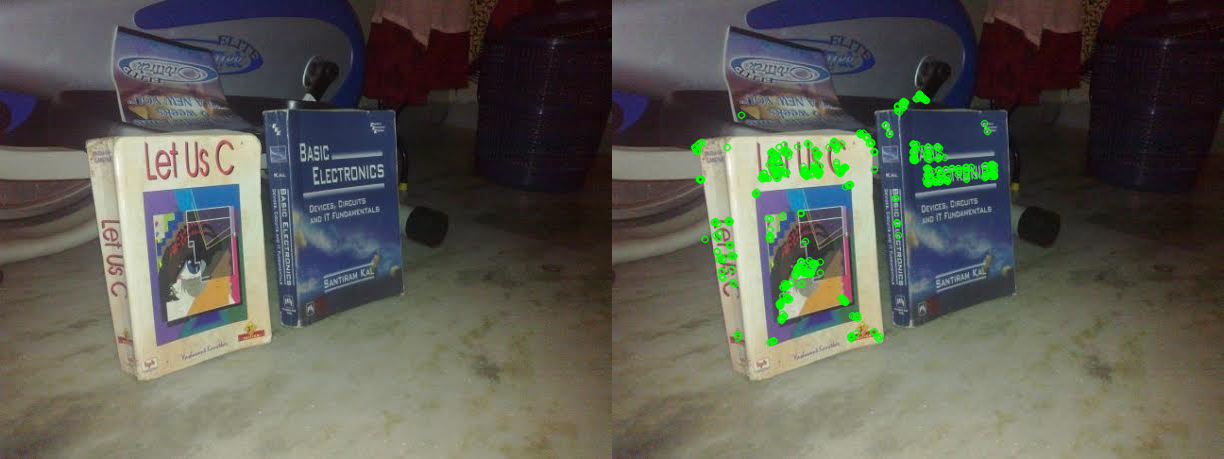

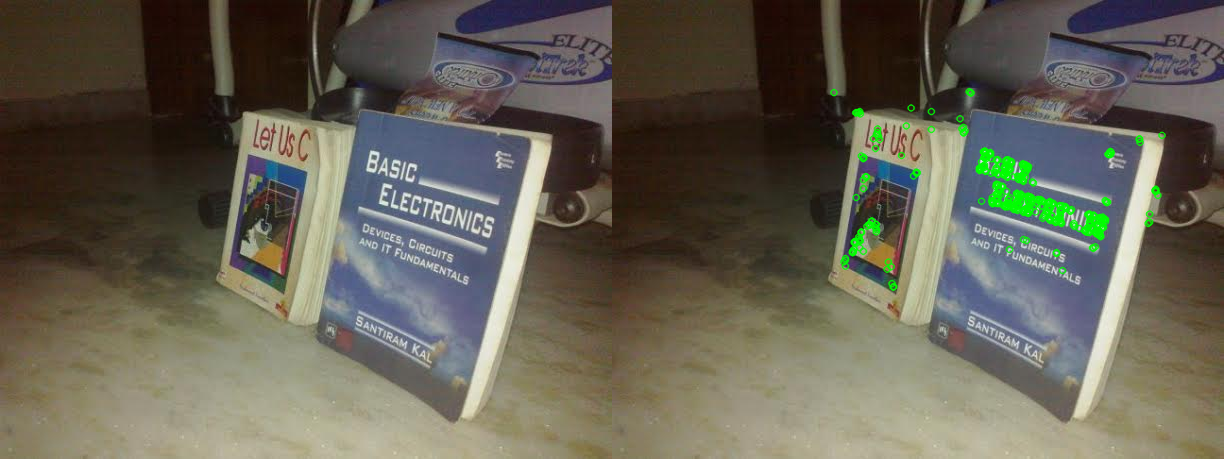

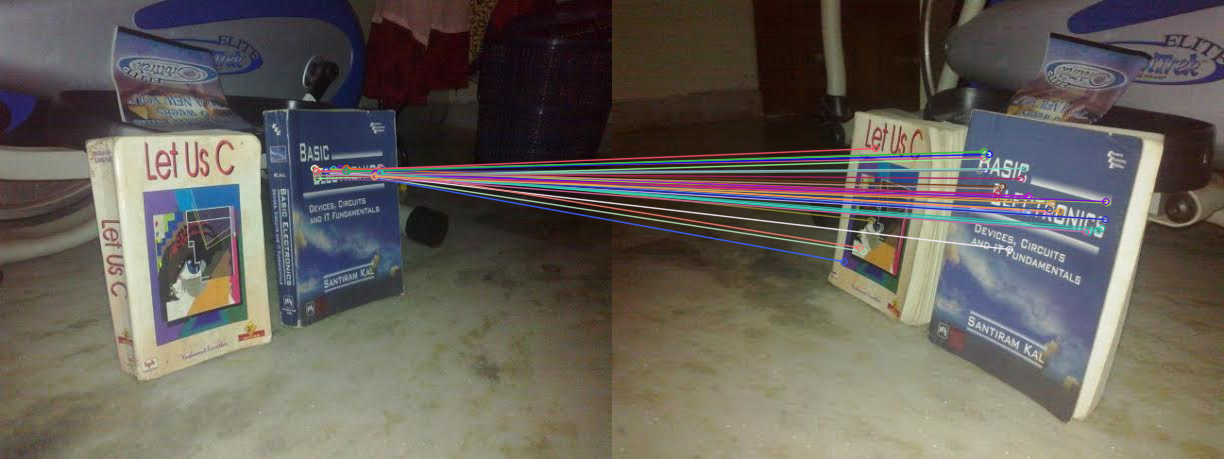

In [16]:
BFMatching(left_path, right_path)

# FLANN

In [17]:
def FLANN(path1, path2, descriptor=orbDescriptor):
  img1 = cv2.imread(path1)
  img2 = cv2.imread(path2)
  kp1, des1 = descriptor(path1)
  kp2, des2 = descriptor(path2)
  des1 = np.float32(des1)
  des2 = np.float32(des2)

  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=50)

  flann = cv2.FlannBasedMatcher(index_params,search_params)
  matches = flann.knnMatch(des1,des2,k=2)

  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches[:20],None,flags=2)
  cv2_imshow(img3)

# Brief Descriptors

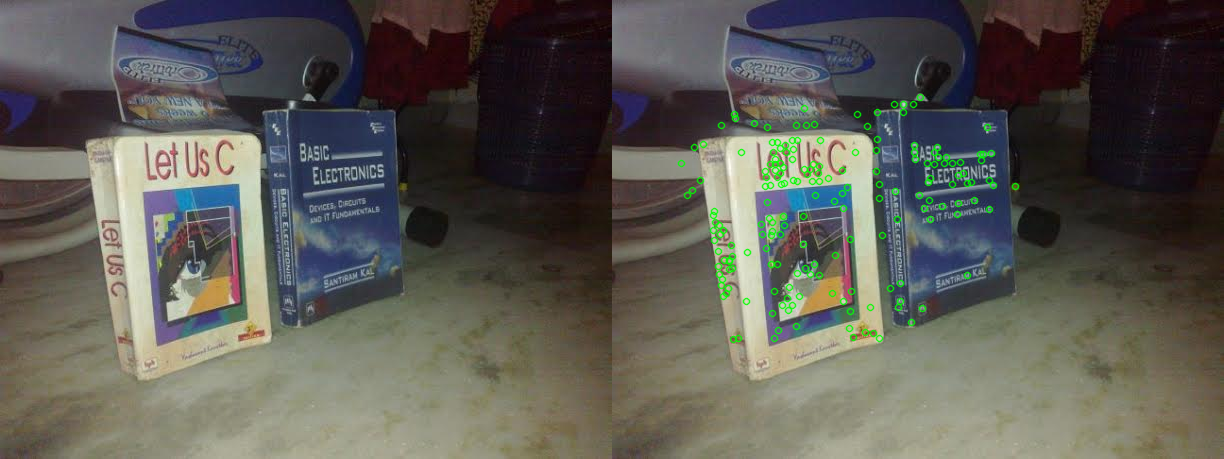

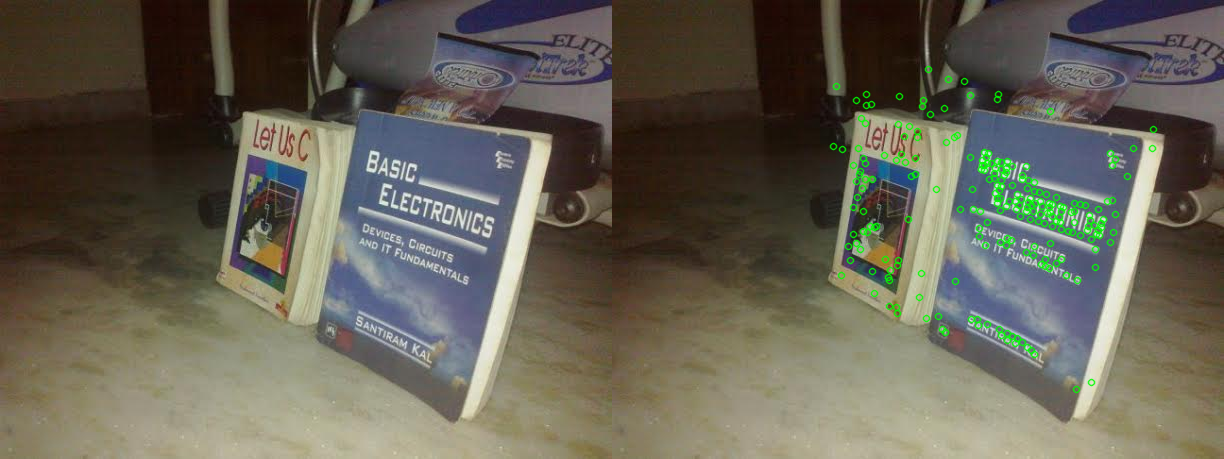

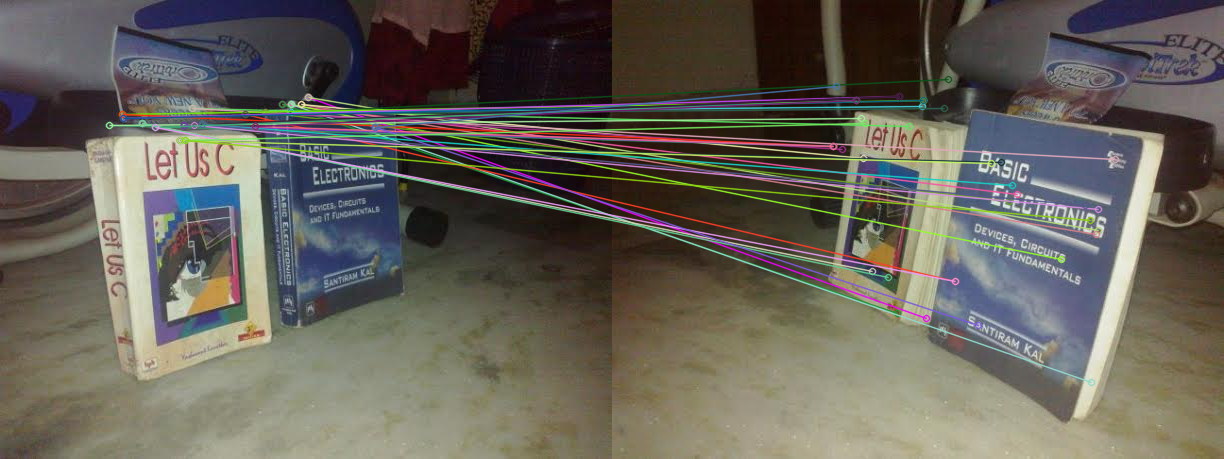

In [18]:
FLANN(left_path,right_path,briefDescriptor)

# Orb Descriptors

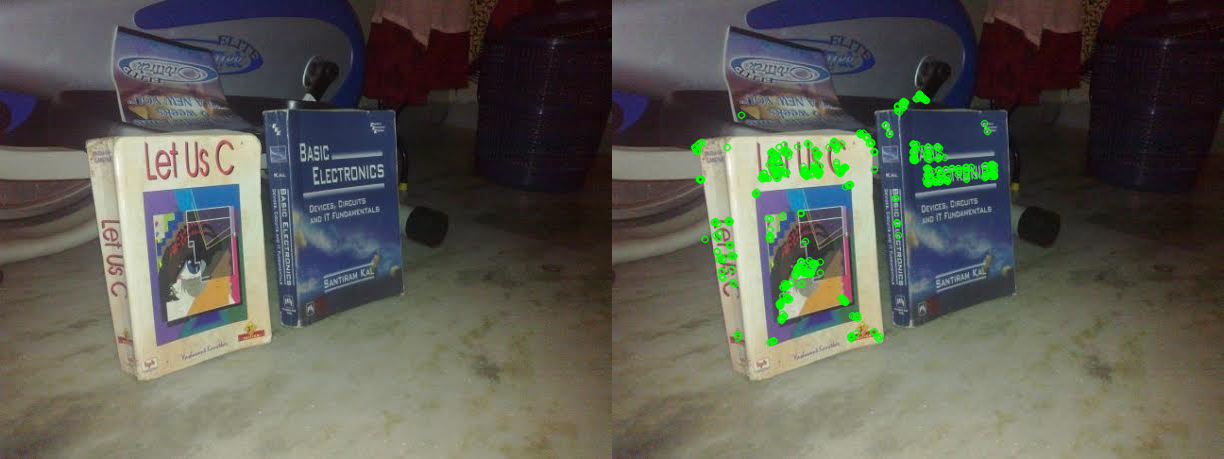

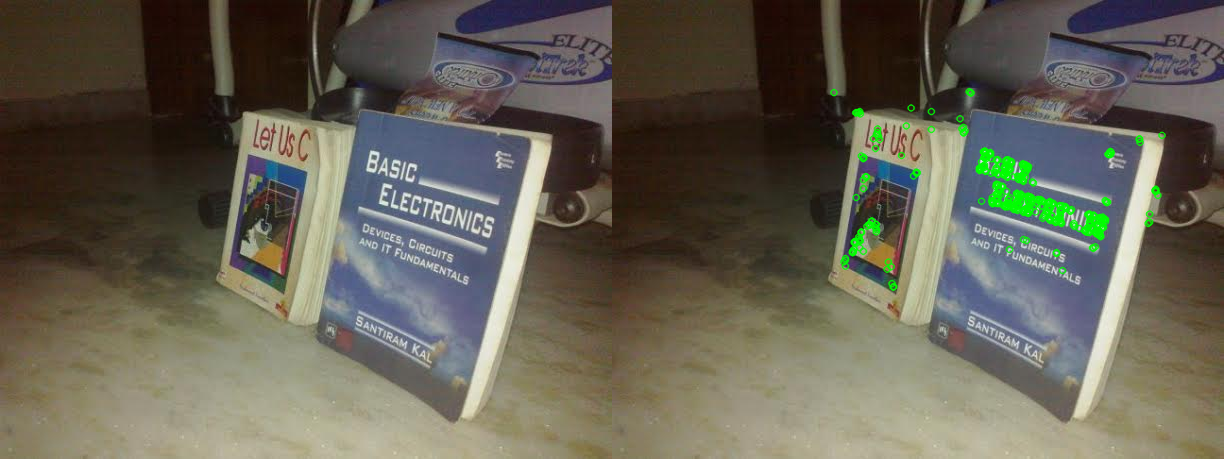

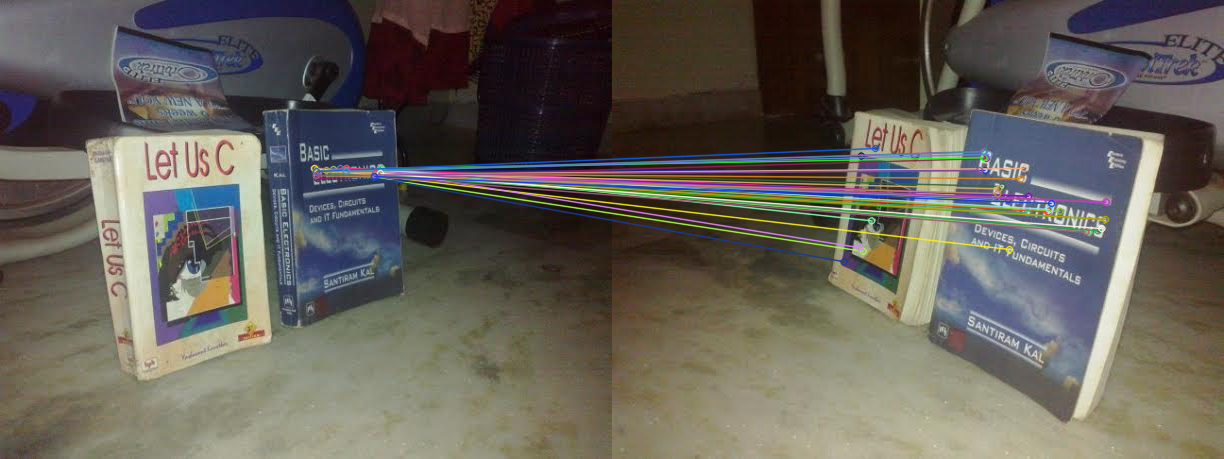

In [19]:
FLANN(left_path,right_path)

## Yêu cầu 3: Stiching

In [20]:
foto1A_path = os.path.join(dir_img,'foto1A.jpg')
foto1B_path = os.path.join(dir_img,'foto1B.jpg')
match1_path = os.path.join(dir_img,'match1.jpg')
match2_path = os.path.join(dir_img,'match2.jpg')

In [29]:
def stitching(pathname1, pathname2):
  img_ = cv2.imread(pathname1)
  img = cv2.imread(pathname2)
  img1 = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  orb = cv2.ORB_create(nfeatures=1500)
  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  rawMatches = bf.knnMatch(des1, des2, 2)
  matches = []
  ratio = 0.75
  for m,n in rawMatches:
    if m.distance < n.distance * 0.75:
      matches.append(m)

  matches = sorted(matches, key=lambda x: x.distance, reverse=True)
  matches = matches[:200]
  img3 = cv2.drawMatches(img_, kp1, img, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  cv2_imshow(img3)
  kp1 = np.float32([kp.pt for kp in kp1])
  kp2 = np.float32([kp.pt for kp in kp2])
  pts1 = np.float32([kp1[m.queryIdx] for m in matches])
  pts2 = np.float32([kp2[m.trainIdx] for m in matches])
  (H, status) = cv2.findHomography(pts2, pts1, cv2.RANSAC)
  h1, w1 = img_.shape[:2]
  h2, w2 = img.shape[:2]
  result = cv2.warpPerspective(img_, H, (w1+w2, h1))
  result[0:h2, 0:w2] = img
  plt.figure(figsize=(20,10))
  plt.imshow(result[:,:,::-1])
  plt.show() 

In [30]:
def stitching1(pathname1, pathname2):
  img_ = cv2.imread(pathname1)
  img = cv2.imread(pathname2)
  img1 = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  orb = cv2.ORB_create(nfeatures=1500)
  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  rawMatches = bf.knnMatch(des1, des2, 2)
  matches = []
  ratio = 0.75
  for m,n in rawMatches:
    if m.distance < n.distance * 0.75:
      matches.append(m)

  matches = sorted(matches, key=lambda x: x.distance, reverse=True)
  matches = matches[:200]
  img3 = cv2.drawMatches(img_, kp1, img, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  cv2_imshow(img3)
  kp1 = np.float32([kp.pt for kp in kp1])
  kp2 = np.float32([kp.pt for kp in kp2])
  pts1 = np.float32([kp1[m.queryIdx] for m in matches])
  pts2 = np.float32([kp2[m.trainIdx] for m in matches])
  (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
  h1, w1 = img_.shape[:2]
  h2, w2 = img.shape[:2]
  result = cv2.warpPerspective(img_, H, (w1+w2, h1))
  result[0:h2, 0:w2] = img
  plt.figure(figsize=(20,10))
  plt.imshow(result[:,:,::-1])
  plt.show() 

In [34]:
stitching1(foto1A_path, foto1B_path)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
stitching(match1_path, match2_path)

Output hidden; open in https://colab.research.google.com to view.